# Social Data Analysis and Visualization: Final Project

In [1]:
import pandas as pd
import numpy as np
import math
import cufflinks as cf
import plotly
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline
import math
from matplotlib import pyplot as plt
import scipy
from sklearn import model_selection, tree, metrics, ensemble
from bokeh import models, plotting
from bokeh.palettes import Spectral8, Spectral11
import seaborn as sns
import pycountry as pc
from bokeh.models import HoverTool
from bokeh.plotting import figure
from bokeh.models import  ColumnDataSource, Legend
from bokeh.io import output_notebook, show, reset_output
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.models import BoxAnnotation
from bokeh.models import Title
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc
from bokeh.models import Range1d
from bokeh.models import LinearAxis
output_notebook()
import bokeh.models as bkm
import regex as re

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
cf.go_offline()

Loading BokehJS ...

In [2]:
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objects as go

chart_studio.tools.set_credentials_file(username='cramosglez', api_key='V4eg5zzwdt7MUlf4eEvp')
chart_studio.tools.set_config_file(world_readable=True, sharing='public')

## Motivation

### What is your dataset?

Different datasets regarding CO2 emissions and their relationship with human activyt and climater change are selected. More specifically, we can find the following datasets:

- CO2 emissions per country 1750 - 2017 -- Source: Kaggle (https://www.kaggle.com/datasets/yoannboyere/co2-ghg-emissionsdata)
- Earth anomalies dataset vs CO2 -- Source: OurWorldInData (https://ourworldindata.org/explorers/climate-change)
- Dataset continents & countries -- Source: Kaggle (https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region)
- Dataset governance (conventions) -- Source: Kaggle (https://www.kaggle.com/datasets/ruchi798/global-environmental-indicators?select=Governance)
- Dataset CO2 per Continent --Source: OurWorldInData (https://ourworldindata.org/co2-emissions)
- Dataset GDP -- Source: World Data Bank (https://data.worldbank.org/indicator/NY.GDP.MKTP.CD)

### Why did you choose this/these particular dataset(s)?

These different datasets allow us to understand the correlation between human activity, CO2 emissions, climate anomalies and country climate commitments. Also, there is a high confidence in them as they either come from reliable sources such as "Our World in Data" or are highly rated in Kaggle.

### What was your goal for the end user's experience?

The main objective of this project is to develop an easy website in which any user can go through different interactive graphics and understand how the CO2 emissions are linked with different topics. More specifically, we want the user to navigate via 3 main categories:
- Emissions vs Earth: Anomalies
- GDP and Population effect on CO2
- Global commitment

## Basic Stats

### CO2 emissions

In [3]:
df_co = pd.read_csv('co2_emission.csv')


In [4]:
print("The dataframe has a total of ", len(df_co.Entity.unique()), "geographical entities")

The dataframe has a total of  233 geographical entities


In [5]:
df_co.describe()

,Year,Annual CO₂ emissions (tonnes )
count,20853.000000,2.085300e+04
mean,1953.339424,1.930517e+08
std,57.903089,1.345143e+09
min,1751.000000,-6.255223e+08
25%,1932.000000,3.187680e+05
50%,1971.000000,3.828880e+06
75%,1995.000000,3.706898e+07
max,2017.000000,3.615326e+10


<AxesSubplot:xlabel='Year'>

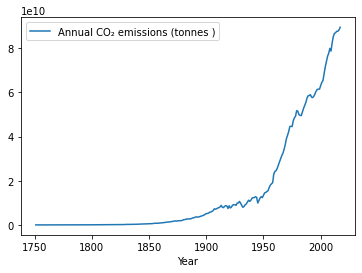

In [6]:
df_co.groupby(by="Year").sum().plot()

We see the CO2 evolution. Let´s see now what is the histogram of emissions in the eyar 2000.

In [7]:
df_co_plot=df_co[df_co["Year"]==2010]

<AxesSubplot:>

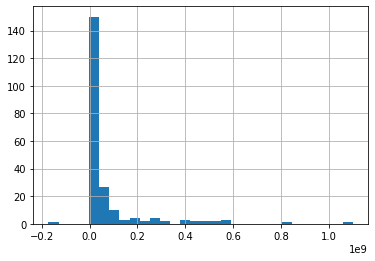

In [8]:
df_co_plot[df_co_plot["Annual CO₂ emissions (tonnes )"]<df_co_plot["Annual CO₂ emissions (tonnes )"].quantile(0.95)]["Annual CO₂ emissions (tonnes )"].hist(bins=30)

In [9]:
df_co.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20853 entries, 0 to 20852
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Entity                          20853 non-null  object 
 1   Code                            18646 non-null  object 
 2   Year                            20853 non-null  int64  
 3   Annual CO₂ emissions (tonnes )  20853 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 651.8+ KB


We need to clean the NA values found, which come from the Code of the Country/Region. This task will be done in preprocessing.

Now, we import the information between countries, regions and code. This is necessary to plot later the countries in the world map.

In [10]:
# Read the coutnries dataset into a data frame
df_inf = pd.read_csv('continents2.csv', usecols=["alpha-3", "region"])

# Rename the column of data frame
df_inf.rename(columns={'alpha-3':'Code', 'region':'Region'}, inplace=True)


<AxesSubplot:>

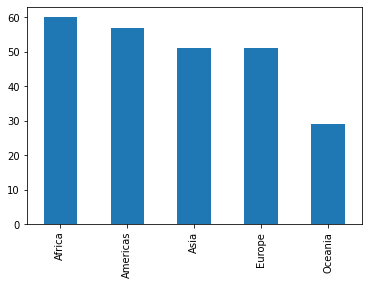

In [11]:
df_inf["Region"].value_counts().plot(kind="bar")

This is the distribution of number of countries per region

### Population

In [12]:
population = pd.read_csv("world-population-by-world-regions-post-1820.csv")

In [13]:
population.describe()

,Year,Population (historical estimates)
count,55656.000000,5.565600e+04
mean,1603.874838,3.246352e+07
std,1416.602466,2.503028e+08
min,-10000.000000,1.000000e+00
25%,1832.000000,1.338740e+05
50%,1899.000000,1.218570e+06
75%,1964.000000,5.396250e+06
max,2021.000000,7.874966e+09


In [14]:
print("The dataframe has: "+str(population.shape[0])+" rows and "+str(population.shape[1])+" columns")

The dataframe has: 55656 rows and 4 columns


<AxesSubplot:xlabel='Year'>

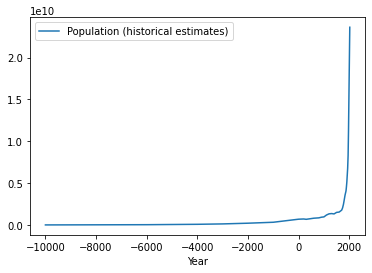

In [15]:
population.groupby(by="Year").sum().plot()

### Continents

In [16]:
continents = pd.read_csv("continents2.csv")

In [17]:
continents.describe()

,country-code,region-code,sub-region-code,intermediate-region-code
count,249.000000,248.000000,248.000000,107.000000
mean,433.835341,65.951613,179.866935,31.719626
std,252.980446,67.347832,138.334170,111.000322
min,4.000000,2.000000,15.000000,5.000000
25%,218.000000,9.000000,53.750000,11.000000
50%,434.000000,19.000000,154.000000,14.000000
75%,652.000000,142.000000,202.000000,29.000000
max,894.000000,150.000000,419.000000,830.000000


In [18]:
print("The dataframe has: "+str(continents.shape[0])+" rows and "+str(continents.shape[1])+" columns")

The dataframe has: 249 rows and 11 columns


<AxesSubplot:>

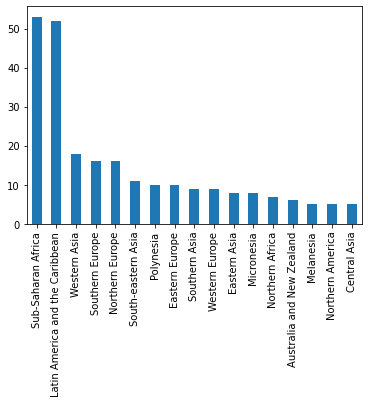

In [19]:
continents["sub-region"].value_counts().plot(kind="bar")

### GDP

In [20]:
gdp = pd.read_csv("gdp_data.csv")

In [21]:
gdp.describe()

,Series Name,Series Code,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
count,268,266,266,266,266,266,266,266,266,266,...,266,266,266,266,266,266,266,266,266,266
unique,3,1,266,266,131,133,136,136,137,147,...,256,257,257,256,255,256,256,252,241,1
top,GDP (current US$),NY.GDP.MKTP.CD,Afghanistan,AFG,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
freq,266,266,1,1,134,132,129,129,129,118,...,9,8,8,9,10,10,10,13,24,266


In [22]:
print("The dataframe has: "+str(gdp.shape[0])+" rows and "+str(gdp.shape[1])+" columns")

The dataframe has: 271 rows and 66 columns


### Anomalies

In [23]:
df_anom=pd.read_csv("phSea.csv")


In [24]:
df_anom.Entity.unique()

array(['Antarctica', 'Greenland', 'Northern Hemisphere',
       'Southern Hemisphere', 'Tropics', 'World'], dtype=object)

In [25]:
df_anom.columns

Index(['Entity', 'Date', 'Combined measurements', 'Seasonal variation',
       'Monthly averaged', 'Annual averaged',
       'monthly_sea_surface_temperature_anomaly',
       'Sea surface temp (lower-bound)', 'Sea surface temp (upper-bound)',
       'Monthly pH measurement', 'Annual average', 'Temperature anomaly',
       'Church & White', 'University of Hawaii', 'Average',
       'arctic_sea_ice_osisaf', 'Monthly averaged.1', 'Annual averaged.1',
       'Monthly averaged.2', 'Annual averaged.2'],
      dtype='object')

In [26]:
df_anom.describe()

,Combined measurements,Seasonal variation,Monthly averaged,Annual averaged,monthly_sea_surface_temperature_anomaly,Sea surface temp (lower-bound),Sea surface temp (upper-bound),Monthly pH measurement,Annual average,Temperature anomaly,Church & White,University of Hawaii,Average,arctic_sea_ice_osisaf,Monthly averaged.1,Annual averaged.1,Monthly averaged.2,Annual averaged.2
count,384.000000,630.000000,251.000000,251.000000,8264.000000,8264.000000,8264.000000,316.000000,305.000000,5121.000000,519.000000,204.000000,563.000000,5.150000e+02,461.000000,461.000000,504.000000,504.000000
mean,-1644.107161,-761.379778,324.470518,324.467729,-0.078548,-0.144124,-0.012739,8.085783,8.085737,0.055856,-93.412393,-5.396936,-82.174304,9.990601e+06,1770.449458,1770.437310,372.554742,372.554782
std,1369.613526,1157.518627,5.462608,5.466768,0.339386,0.355109,0.326078,0.021438,0.015955,0.397764,58.380687,36.176961,68.087946,3.225729e+06,61.196151,60.994816,22.406005,22.375789
min,-4996.080000,-3651.033610,316.100000,316.000000,-0.992820,-1.055500,-0.917000,8.027200,8.049200,-1.520000,-204.380729,-70.868888,-204.380730,2.948063e+06,1625.900000,1634.800000,337.050000,337.930000
25%,-2412.562500,-1474.515172,319.700000,319.650000,-0.324402,-0.399000,-0.251500,8.070375,8.073600,-0.230000,-141.214063,-32.704863,-138.414065,7.260940e+06,1736.700000,1735.600000,354.000000,353.800000
50%,-1321.760000,-242.047233,324.100000,324.200000,-0.133970,-0.211500,-0.052000,8.085600,8.086600,-0.030000,-101.480729,-9.342248,-87.447400,1.047879e+07,1774.600000,1773.500000,369.840000,369.660000
75%,-491.047500,151.804958,328.900000,329.050000,0.134010,0.072000,0.194000,8.099300,8.097400,0.290000,-43.730729,16.291852,-28.782705,1.298226e+07,1808.300000,1807.300000,390.645000,390.575000
max,67.360000,467.965526,334.800000,334.700000,1.180990,1.151000,1.209500,8.150800,8.114500,1.940000,38.085938,68.811630,68.811630,1.470035e+07,1909.300000,1901.000000,416.870000,416.240000


In [27]:
dataset_anom=df_co.groupby(by="Year").sum()

### Countries

In [28]:
# Countries
df_countries = pd.read_csv('continents2.csv')
df_countries.rename(columns = {'country-code':'CountryID'}, inplace = True)

# Lists
id_list = df_countries['CountryID'].to_list()
alpha_list = df_countries['alpha-3'].to_list()
name_list = df_countries['name'].to_list()

# dictionaries
id_alpha = dict(zip(id_list, alpha_list)) # get 'alpha-3' by 'id'
id_name = dict(zip(id_list, name_list)) # get 'name' by 'id'
alpha_id = dict(zip(alpha_list, id_list)) # get 'id'by 'alpha-3'
alpha_name = dict(zip(alpha_list, name_list)) # get 'id'by 'name'

# check that values are unique and are consistent
if len(id_list) == len(alpha_list) == len(name_list) == len(df_countries['CountryID'].unique()):
    print('There are ' + str(len(alpha_list)) + ' entities')
else:
    print('Number of countries INCONSISTENT')

There are 249 entities


### Conventions

In [29]:
def cleandf_E(df):
    N, M = df.shape
    df = df.iloc[:, 0:M]
    df = df.replace('...', np.nan)
    df = df.replace('…', np.nan)
    df = df.replace(',','', regex = True)
    c = df.select_dtypes(object).columns
    df[c] = df[c].apply(pd.to_numeric, errors = 'coerce')
    return df


# emissions datasets contain entities other than countries (regions, world, etc.)
# this funcion returns only the rows for countries
def is_country(data):

    is_country = []

    for index, rows in data["Code"].iteritems():
        if rows != 'nan':
            country = pc.countries.get(alpha_3=rows)
            if country != None:
                is_country.append(True)
            else:
                is_country.append(False)
        else:
            continue

    data["Is Country"] = is_country
    data = data[data["Is Country"] == True]
    data = data.drop(columns=["Is Country"])
    
    return data

194 countries included in this dataset
4


<AxesSubplot:>

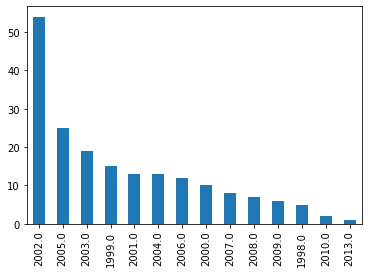

In [30]:
df_governance = pd.read_csv('Governance.csv')
df_gov = cleandf_E(df_governance)

df_Kyoto = pd.DataFrame()
df_Kyoto['ID'] = df_gov['CountryID']
df_Kyoto['Year'] = df_gov['Kyoto \nProtocol']

# the 3 following arrays contain the countries that joined the Kyoto Protocol
# there's an array for each period: before 2008, between 2008-2012, after 2012
# countries that never joined are the remaining
id_Kyoto_2008 = np.array(df_Kyoto.loc[df_Kyoto['Year'] < 2008, 'ID'])
id_Kyoto_2012 = np.array(df_Kyoto.loc[((df_Kyoto['Year'] >= 2008) & (df_Kyoto['Year'] < 2012)), 'ID'])
id_Kyoto_after = np.array(df_Kyoto.loc[df_Kyoto['Year'] > 2012, 'ID'])

a = df_governance['CountryID'].count()
b = df_Kyoto['ID'].count()
# check that values are unique and are consistent
if a == b:
    print(str(b) + ' countries included in this dataset')
else:
    print('Number of countries INCONSISTENT')
    
K08 = len(id_Kyoto_2008)
K12 = len(id_Kyoto_2012)
Kafter = len(id_Kyoto_after)
c = b - K08 - K12 - Kafter
print(c)

df_Kyoto['Year'].value_counts().plot(kind="bar")

### Emissions vs Earth

#### CO2 evolution per country since 1900

In [31]:
df_co.dropna(inplace=True)
df_co.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18646 entries, 0 to 20852
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Entity                          18646 non-null  object 
 1   Code                            18646 non-null  object 
 2   Year                            18646 non-null  int64  
 3   Annual CO₂ emissions (tonnes )  18646 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 728.4+ KB


In [32]:
df_co.sort_values(['Entity', 'Year'])

,Entity,Code,Year,Annual CO₂ emissions (tonnes )
0,Afghanistan,AFG,1949,14656.00
1,Afghanistan,AFG,1950,84272.00
2,Afghanistan,AFG,1951,91600.00
3,Afghanistan,AFG,1952,91600.00
4,Afghanistan,AFG,1953,106256.00
...,...,...,...,...
20848,Zimbabwe,ZWE,2013,11536239.29
20849,Zimbabwe,ZWE,2014,11866348.41
20850,Zimbabwe,ZWE,2015,10907603.94
20851,Zimbabwe,ZWE,2016,9932649.88


In [33]:
df_merged = pd.merge(df_co, df_inf, how='left', on='Code')


In [34]:
df_merged=df_merged[df_merged["Year"]>1900]
df_merged=df_merged[df_merged.Year % 5==0]

#### CO2 per Region

The 2 datasets are extracted from OurWorldinData.
2 filters are applied in every dataset: The starting year of the data will be 1900 and 6 geographical entities are shown as categories.

In [35]:
Ents=["Asia","Europe","North America","South America","Africa","Oceania"]
share=pd.read_csv("annual-share-of-co2-emissions.csv")
share=share[share["Year"]>1900]
share=share[share['Entity'].isin(Ents)]

In [36]:
tot=pd.read_csv("annual-co2-emissions-per-country.csv")
tot=tot[tot["Year"]>1900]
tot=tot[tot['Entity'].isin(Ents)]

#### Climate Change Metrics

In [37]:
df_anom['Year']=pd.to_datetime(df_anom['Date'],infer_datetime_format=True).dt.year
df_nh=df_anom[df_anom["Entity"]=="Northern Hemisphere"]
df_sh=df_anom[df_anom["Entity"]=="Southern Hemisphere"]
df_tr=df_anom[df_anom["Entity"]=="Tropics"]
df_global=df_anom[df_anom["Entity"]=="World"]

df_nh=df_nh.groupby(by="Year").mean()
df_sh=df_sh.groupby(by="Year").mean()
df_tr=df_tr.groupby(by="Year").mean()
df_global=df_global.groupby(by="Year").mean()

In [38]:
dataset_anom=pd.merge(dataset_anom, df_global, left_index=True, right_index=True)

In [39]:
dataset_anom.rename(columns = 
               {'Annual CO₂ emissions (tonnes )':'CO2', 
                'monthly_sea_surface_temperature_anomaly':'SEA_AVG',
                'Sea surface temp (lower-bound)':'SEA_LOW',
                'Sea surface temp (upper-bound)':'SEA_UP',
                'Annual average':'PH',
                'Temperature anomaly':'Temp',
                'Average':'Sealevel'}, inplace = True)

In [40]:
dataset_anom["Temp_NH"]=df_nh["Temperature anomaly"]
dataset_anom["Temp_SH"]=df_sh["Temperature anomaly"]
dataset_anom["Temp_TR"]=df_tr["Temperature anomaly"]
dataset_anom.reset_index(inplace=True)

### GDP and Population relationship with CO2

We start by uploading the necessary dataframes

In [41]:
#Historic CO2 emissions per country, region and world.
co2 = pd.read_csv("co2_emission.csv") 
#Historic estimates on populations
population = pd.read_csv("world-population-by-world-regions-post-1820.csv") #
# Information of country, continent and sub-region
continents = pd.read_csv("continents2.csv")
#Information on GDP per country, region and world
gdp = pd.read_csv("gdp_data.csv")

## World Data
We want to begin by analyzing the data worldwide to find trends and identify patterns that can help us with our analysis. We start by filtering the CO2 and Population data by entity and keeping only the "World" entity which has the total aggregate of worldwide data of each indicator.

In [42]:
populationW = population[population["Entity"] == "World"]
co2W = co2[co2["Entity"] == "World"]

In order to have extra information to make the different analysis we proceed to calculate the tonnes of CO2 per population or per Capita.

Since the population dataframe has estimates of population dating back to 10.000 BC, we proceed to merge both dataframes using an inner join using the Year as the id column so that we have the population and CO2 emissions for the same years.

In [43]:
co2_per_capita = pd.merge(co2W, populationW, how="inner", on="Year")

In [44]:
#We keep only the important columns of the merge

co2_per_capita = co2_per_capita[["Year","Annual CO₂ emissions (tonnes )", "Population (historical estimates)"]]

In [45]:
# Calculation of the CO2 emmissions per capita amd rename of the columns

co2_per_capita["CO2 per Capita"] = co2_per_capita["Annual CO₂ emissions (tonnes )"]/co2_per_capita["Population (historical estimates)"]
co2_per_capita.columns = ['Year', 'Tons_CO2', 'Population', 'CO2_per_Capita']

Once this is calculated, we proceed to work in the GDP dataset. In this case the dataset is not in the most optimal form because the information of the years are the columns of the dataset instead of a column.

In [46]:
gdp.head(3)

,Series Name,Series Code,Country Name,Country Code,1960 [YR1960],1961 [YR1961],1962 [YR1962],1963 [YR1963],1964 [YR1964],1965 [YR1965],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,GDP (current US$),NY.GDP.MKTP.CD,Afghanistan,AFG,537777811.111111,548888895.555556,546666677.777778,751111191.111111,800000044.444444,1006666637.77778,...,19907317065.6666,20146404996.223,20497126770.1335,19134211763.859,18116562464.9088,18753469630.2586,18053228578.8878,18799450742.7823,20116137325.8206,..
1,GDP (current US$),NY.GDP.MKTP.CD,Albania,ALB,..,..,..,..,..,..,...,12319830437.3467,12776220507.0162,13228147516.1168,11386850129.8411,11861199830.8396,13019689336.6919,15156432309.8977,15400242874.8812,14887629268.2927,..
2,GDP (current US$),NY.GDP.MKTP.CD,Algeria,DZA,2723593384.78054,2434727329.809,2001428328.37091,2702960118.28806,2909292864.23204,3136258896.9233,...,209058991952.125,209755003250.664,213810024944.464,165979279263.174,160034163871.455,170097014589.134,174910878623.049,171767403748.19,145009181490.62,..


In [47]:
# We keep only the important rows

gdpW = gdp[gdp["Country Name"] == "World"]

When we have the data we want to use, we proceed to do a melt operation using the "Country Name" as the id of the operation. This will transform the column data into a rows, which is what we need.

In [48]:
gdp_melt = gdpW.melt(id_vars = "Country Name")
gdp_melt

,Country Name,variable,value
0,World,Series Name,GDP (current US$)
1,World,Series Code,NY.GDP.MKTP.CD
2,World,Country Code,WLD
3,World,1960 [YR1960],1390297773982.95
4,World,1961 [YR1961],1446418444335.74
...,...,...,...
60,World,2017 [YR2017],81224639219699.2
61,World,2018 [YR2018],86274296671018.8
62,World,2019 [YR2019],87568054060440.9
63,World,2020 [YR2020],84746978784172.8


In [49]:
# Remove the first three rows that have unnecessary data

gdp_melt = gdp_melt.tail(gdp_melt.shape[0] -3)

Now, the year data is not in the correct format. To correct this we create a new column using the regex pattern '[\w+\d+] to look for all the unnecessary data in the column and remove it.

The \ [ and \ ] are used to search for the open and close square brackets. \w+ will look for one or more consecutive letters and trhe \d+ will look for one or more consecutive numbers in the string. Since all the years are in XXXX [YRXXXX] format, this will look and remove all the [YRXXXX].

In [50]:
year = []

for index, rows in gdp_melt['variable'].iteritems():
    txt = re.sub(r'\[\w+\d+\]', "",rows)
    year.append(txt)
    

gdp_melt["Year"] = year

In [51]:
# Making the new Year column the correct format

gdp_melt["Year"] = pd.to_numeric(gdp_melt["Year"],errors = 'coerce')

Finally we merge the CO2 and population data from before with the GDP data to obtain a complete dataset with all the aggregated data worldwide.

In [52]:
data_world= pd.merge(co2_per_capita, gdp_melt, how="inner", on="Year")

In [53]:
#Drop unnecessary columns and change column names

data_world = data_world.drop(columns = ["Country Name", "variable"])
data_world.columns = ['Year', 'Tons_CO2', 'Population', 'CO2_per_Capita', 'Global_GDP']

In [54]:
# Global GDP data to the correct format

data_world["Global_GDP"] = pd.to_numeric(data_world["Global_GDP"],errors = 'coerce')

Now we proceed to calculate the GDP per Capita using the GDP information and the Population.

In [55]:
data_world["GDP_per_Capita"] = round(data_world["Global_GDP"]/data_world["Population"],2)

We proceed to create graphs based on the dataset we just finished creating. These are created using Bokeh for an easier integration with our webpage.

In [56]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p1 = plotting.figure(title = 'Relation CO2 and GDP', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600)

#Creating an extra Y axes for plotting both lines
p1.extra_y_ranges = {"sec": Range1d(data_world.Tons_CO2.min(), data_world.Tons_CO2.max())}

# Global GDP per year
plot1= p1.line(x = 'Year', y = 'Global_GDP', source = source, legend_label = 'Global GDP',
        color = Spectral11[1], line_width = 3)

#Global emmisions of CO2
plot2 = p1.line(x = 'Year', y = 'Tons_CO2', source = source, y_range_name="sec",legend_label = 'Tons of CO2',
        color = Spectral11[6], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p1.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Global GDP', '@Global_GDP{0.00}')], renderers=[plot1]))
p1.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Tons_CO2', '@Tons_CO2{0.00}')], renderers=[plot2]))

#Legend information and definition
p1.legend.location = 'bottom_right'
p1.legend.background_fill_alpha = 0.25
p1.legend.background_fill_color = 'darkgray'
p1.legend.border_line_alpha = 0
p1.title.align = 'center'

show(p1)

In [57]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p2 = plotting.figure(title = 'Relation Population and GDP', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600)

#Creating an extra Y axes for plotting both lines
p2.extra_y_ranges = {"sec": Range1d(data_world.Population.min(), data_world.Population.max())}

# Global GDP per year
plot1= p2.line(x = 'Year', y = 'Global_GDP', source = source, legend_label = 'Global GDP',
        color = Spectral11[1], line_width = 3)

#Estimated population per year
plot2 = p2.line(x = 'Year', y = 'Population', source = source, y_range_name="sec",legend_label = 'Population',
        color = Spectral11[3], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p2.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Global GDP', '@Global_GDP{0.00}')], renderers=[plot1]))
p2.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Population', '@Population{0.00}')], renderers=[plot2]))

#Legend information and definition
p2.legend.location = 'bottom_right'
p2.legend.background_fill_alpha = 0.25
p2.legend.background_fill_color = 'darkgray'
p2.legend.border_line_alpha = 0
p2.title.align = 'center'

show(p2)

In [58]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p3 = plotting.figure(title = 'Relation CO2 and Population', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600)

#Creating an extra Y axes for plotting both lines
p3.extra_y_ranges = {"sec": Range1d(data_world.Population.min(), data_world.Population.max())}

plot1= p3.line(x = 'Year', y = 'Tons_CO2', source = source,legend_label = 'Tons of CO2',
        color = Spectral11[6], line_width = 3)

#Estimated population per year
plot2 = p3.line(x = 'Year', y = 'Population', source = source, y_range_name="sec",legend_label = 'Population',
        color = Spectral11[3], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p3.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Tons_CO2', '@Tons_CO2{0.00}')], renderers=[plot1]))
p3.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Population', '@Population{0.00}')], renderers=[plot2]))

#Legend information and definition
p3.legend.location = 'bottom_right'
p3.legend.background_fill_alpha = 0.25
p3.legend.background_fill_color = 'darkgray'
p3.legend.border_line_alpha = 0
p3.title.align = 'center'

show(p3)

The Gross domestic product (GDP) can be defined as the total value of all the finished goods and services produced within a country’s borders in a specific time period. In other words, it is the total amount of money a country produces thanks to its goods and services.

The GDP functions as a comprehensive scorecard of a given country’s economic health. If the GDP of a country/region is rising over the years, it indicates a growing economy and industry, and that the economy is in solid shape. The opposite is also true, a decreasing GDP over the years or a time period is an indication that the economy might be slowing and/or in trouble.

In the graphics below, we can see different relationships between tons of CO2 produced worldwide, global GDP and world population through the years.

In [59]:
#Creating the different pages of the visualization using the graphs we created above. 
#We use "stretch_both" for sizing mode to have a responsive graph

#Creating a figure that stores the graphs
fig1=p1
fig2=p2
fig3=p3

#Defining the layout and sizing mode ogf the graphs
l1 = layout([[fig1]], sizing_mode="stretch_both")
l2 = layout([[fig2]], sizing_mode="stretch_both")
l3 = layout([[fig3]], sizing_mode="stretch_both")


#Creating each of the tabs in the interactive graph.
tab1 = Panel(child=l1,title="CO2 vs GDP")
tab2 = Panel(child=l2,title="CO2 vs Population")
tab3 = Panel(child=l3,title="Population vs GDP")


#Creating an object to store and display the graphs
tabs = Tabs(tabs=[ tab1, tab2, tab3 ])
curdoc().add_root(tabs)

#Show the graphs
show(tabs)

In [60]:
# Creating an html file from the information of the graph so that we can embed it into our website
from bokeh.embed import file_html
from bokeh.resources import CDN
html=file_html(tabs, CDN, "COperCapita")
#print(html)

As can be seen in the graphs, there is a direct possitive correlation between the three measurements. The higher the global GDP or population, the higher the CO2 emissions. On a world scale this can be explained since the concept of GDP itself is defined as the value of all final products and services produced in one period. Given this, when production increases, products and pollution increase as a result. Additionally, production is directly associated with the obligation of a society of satisfying the needs of its population, given this, an increase in population implies an increase in production, an finally an increase in CO2 emissions.

To show a better relationship between this measures we show the GDP per Capita vs the tons of CO2 per Capita. This indicators show the amount of GDP and the tons of produced CO2 that are associated to each individual of the population. In the graph below, we can see that there is an increassing amount of GDP and CO2 per Capita through the years, meanning that the more GDP worldwide can be associated with a person, the higher its carbon footprint and the amount of CO2 associated with them.

In [61]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p4 = plotting.figure(title = 'Relation CO2 per Capita and GDP per Capita', x_axis_label = 'Year', 
                     y_axis_label = 'GDP', plot_width = 800, plot_height = 600)

#Creating an extra Y axes for plotting both lines
p4.extra_y_ranges = {"sec": Range1d(data_world.CO2_per_Capita.min(), data_world.CO2_per_Capita.max())}

#CO2 per Capita line
plot1= p4.line(x = 'Year', y = 'CO2_per_Capita', source = source, y_range_name="sec",legend_label = 'Tons of CO2',
        color = Spectral11[1], line_width = 3)

#GDP per Capita line
plot2 = p4.line(x = 'Year', y = 'GDP_per_Capita', source = source,legend_label = 'GDP_per_Capita',
        color = Spectral11[9], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p4.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('CO2_per_Capita', '@CO2_per_Capita{0.00}')], renderers=[plot1]))
p4.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('GDP_per_Capita', '@GDP_per_Capita{0.00}')], renderers=[plot2]))

#Legend information and definition
p4.legend.location = 'bottom_right'
p4.legend.background_fill_alpha = 0.25
p4.legend.background_fill_color = 'darkgray'
p4.legend.border_line_alpha = 0
p4.title.align = 'center'

show(p4)

In [62]:
#HTML file

html=file_html(p4, CDN, "COperCapita")
#print(html)

## Country data
We start this section by creating new datasets to store the data from countries only.

In [63]:
#Eliminate all rows that do not have a country code.
gdpC = gdp.dropna( how='all', subset=['Country Code'])

#Drop unnecessary columns
gdpC = gdpC.drop(columns=["Series Code","Series Name"])

#Rename columns for future merge
gdpC.rename(columns = {'Country Code':'Code'}, inplace = True)

In [64]:
#Drop unnecessary column
continentsC  = continents.drop(columns=['alpha-2', 'country-code', 'iso_3166-2','intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code'])

#Rename columns for future merge
continentsC.rename(columns = {'alpha-3':'Code'}, inplace = True)

In [65]:
#Remove rows that do not have a country code.

co2C = co2[co2["Code"].notna()]
populationC = population[population["Code"].notna()]

Unfortunately, droping na from the last datasets do not remove all the rows that are not countries. To make sure that the remaining rows are countries we use the pycountries library. It contains a dictionary of countries with different attributes like name, country code and others. We use this to compare the country code of each row and keep only the ones that are countries.

In [66]:
#Function that checks if row is a country or not.

def is_country(data):

    #List that stores if it is a country or not
    is_country = []

    for index, rows in data["Code"].iteritems():
        if rows != 'nan':
            country = pc.countries.get(alpha_3=rows)
            if country != None:
                is_country.append(True)
            else:
                is_country.append(False)
        else:
            continue

    data["Is Country"] = is_country
    data = data[data["Is Country"] == True]
    data = data.drop(columns=["Is Country"])
    
    return data

In [67]:
#Checks if all columns are countries and eliminate the rest

co2C = is_country(co2C)
populationC = is_country(populationC)
continentsC = is_country(continentsC)
gdpC = is_country(gdpC)

Once we are sure that the datasets only contain countries, we proceed to use the meld operation explained before to transform all the column data from the GDP dataset into a column where the country and country code are the ids.

In [68]:
gdp_melt = gdpC.melt(id_vars = ["Country Name", "Code"])

In [69]:
#Conversion of year into a column

year = []

for index, rows in gdp_melt['variable'].iteritems():
    txt = re.sub(r'\[\w+\d+\]', "",rows)
    year.append(txt)
    

gdp_melt["Year"] = year

#Convert column to correct format
gdp_melt["Year"] = pd.to_numeric(gdp_melt["Year"])

#Sort the dataset by Country name and Year so that all the countries are in alfabethical order and rows are sorted by year. 
#Since the data start on 1960, it will appear a country from 1960-2021, next country from 1960-2021 and so on.
gdp_melt.sort_values(by=['Country Name', 'Year'], inplace=True)

Some of the values of the GDP have not been recorded, especially for decades where it was not relevant or some of the countries did not exist. In the case of a missing value, instead of an na, the dataset has two dots(..). The following code replace the two dots for a na value so that it is easier later to correct this.

In [70]:
#Removes the .. from the cells and replace it with na
gdp_melt.value = gdp_melt.value.replace(to_replace=r'\.\.', value = np.nan, regex=True)

#Converts the column to the correct format.
gdp_melt.value =  pd.to_numeric(gdp_melt.value)

In [71]:
#Reset index for easier processing
gdp_melt = gdp_melt.reset_index()

Now we peoceed to process the na values that we added to the GDP values column. For this, we have to follow below steps.

1) Since the data we have starts in 1960, we will proceed to set the missing values of all 1960 years to 0. This will ensure that all countries have an initial GDP of at least 0 in case they do not have data for that year.

2) We also copy all the values from the rest of the years into the new value column.

We will assume that if some data is missing, we can estimate that it will be at least equal to the last value that appear in the column. Because of the previous step, all countries have an initial GDP or a 0 in case the value was missing.

3) We proceed to use the ffill method of the fillna function, this will copy the previous known value within the column into the missing cells.

This will ensure that the data is correctly used and that we do not use incorrect data in the ffill method.

In [72]:
import math

GDP = []


for index, rows in gdp_melt.iterrows():
    #Fill all the 1960s' values with either their value or 0
    if rows["Year"] == 1960:
        if math.isnan(rows['value']):
            GDP.append(0)
        else:
            GDP.append(rows['value'])
    #if it is not 1960, just copy the value
    else:
        GDP.append(rows['value']) 

#Create a new column with the correct GDP data
gdp_melt['GDP'] = GDP   

In [73]:
#Use the ffill method to fill the columns
gdp_melt = gdp_melt.fillna(method = 'ffill')

For the Country analysis we want to see only their progress in specific years. This help to reduce the unnecessary data and to see the changes in a better and more significant way. We decided to show the data of every 20 years starting with 1960.

The data we have is from 1960 until 2017, so for the last graph the data is from 2017 instead of 2020, however, since the data is from a 17 years difference, we consider to be significant enough to be relevant

In [74]:
#Filtering the data from 1960, 1980, 2000, and 2017 from all datasets
co2_60 = co2C[co2C['Year'] == 1960]
co2_80 = co2C[co2C['Year'] == 1980]
co2_00 = co2C[co2C['Year'] == 2000]
co2_17 = co2C[co2C['Year'] == 2017]

population_60 = populationC[populationC['Year'] == 1960]
population_80 = populationC[populationC['Year'] == 1980]
population_00 = populationC[populationC['Year'] == 2000]
population_17 = populationC[populationC['Year'] == 2017]

gdp_melt_60 = gdp_melt[gdp_melt['Year'] == 1960]
gdp_melt_80 = gdp_melt[gdp_melt['Year'] == 1980]
gdp_melt_00 = gdp_melt[gdp_melt['Year'] == 2000]
gdp_melt_17 = gdp_melt[gdp_melt['Year'] == 2017]

Now that we have filtered the relevant data, we will proceed to create a new dataset for each year. For this we will use a merge on the Code column, since the data from one year should have every country only once. Once this is done, we keep the important columns and rename them for easier readability and use.

In [75]:
#The merge function takes only two datasets at a time, since we want to merge 4 datasets we need to use the functiuon three times.
data_60= pd.merge(co2_60, population_60, how="inner", on="Code")
data_60 = pd.merge(data_60, gdp_melt_60, how="inner", on="Code")
data_60 = pd.merge(data_60, continentsC, how="inner", on="Code")
data_60 = data_60[['Code','name',  'region', 'sub-region', 'Annual CO₂ emissions (tonnes )',
       'Population (historical estimates)', 'GDP']]
                   
data_60.columns =['Code','Country',  'Region', 'Sub-region', 'CO2_Emissions', 'Population', 'GDP']

In [76]:
#The merge function takes only two datasets at a time, since we want to merge 4 datasets we need to use the functiuon three times.
data_80= pd.merge(co2_80, population_80, how="inner", on="Code")
data_80 = pd.merge(data_80, gdp_melt_80, how="inner", on="Code")
data_80 = pd.merge(data_80, continentsC, how="inner", on="Code")
data_80 = data_80[['Code','name',  'region', 'sub-region', 'Annual CO₂ emissions (tonnes )',
       'Population (historical estimates)', 'GDP']]
                   
data_80.columns =['Code','Country',  'Region', 'Sub-region', 'CO2_Emissions', 'Population', 'GDP']

In [77]:
#The merge function takes only two datasets at a time, since we want to merge 4 datasets we need to use the functiuon three times.
data_00= pd.merge(co2_00, population_00, how="inner", on="Code")
data_00 = pd.merge(data_00, gdp_melt_00, how="inner", on="Code")
data_00 = pd.merge(data_00, continentsC, how="inner", on="Code")
data_00 = data_00[['Code','name',  'region', 'sub-region', 'Annual CO₂ emissions (tonnes )',
       'Population (historical estimates)', 'GDP']]
                   
data_00.columns =['Code','Country',  'Region', 'Sub-region', 'CO2_Emissions', 'Population', 'GDP']

In [78]:
#The merge function takes only two datasets at a time, since we want to merge 4 datasets we need to use the functiuon three times.
data_17= pd.merge(co2_17, population_17, how="inner", on="Code")
data_17 = pd.merge(data_17, gdp_melt_17, how="inner", on="Code")
data_17 = pd.merge(data_17, continentsC, how="inner", on="Code")
data_17 = data_17[['Code','name',  'region', 'sub-region', 'Annual CO₂ emissions (tonnes )',
       'Population (historical estimates)', 'GDP']]
                   
data_17.columns =['Code','Country',  'Region', 'Sub-region', 'CO2_Emissions', 'Population', 'GDP']

We proceed to convert the GDP column to the correct format and we calculate the CO2 emissions and GDP per Capita on each of the datasets.

In [79]:
data_60["GDP"] = pd.to_numeric(data_60["GDP"])
data_60["CO2_Cap"] = data_60["CO2_Emissions"]/data_60["Population"]
data_60["GDP_Cap"] = data_60["GDP"]/data_60["Population"]

data_80["GDP"] = pd.to_numeric(data_80["GDP"])
data_80["CO2_Cap"] = data_80["CO2_Emissions"]/data_80["Population"]
data_80["GDP_Cap"] = data_80["GDP"]/data_80["Population"]

data_00["GDP"] = pd.to_numeric(data_00["GDP"])
data_00["CO2_Cap"] = data_00["CO2_Emissions"]/data_00["Population"]
data_00["GDP_Cap"] = data_00["GDP"]/data_00["Population"]

data_17["GDP"] = pd.to_numeric(data_17["GDP"])
data_17["CO2_Cap"] = data_17["CO2_Emissions"]/data_17["Population"]
data_17["GDP_Cap"] = data_17["GDP"]/data_17["Population"]

With the data ready, we proceed to create the graphs for each relevant year. We create first the graphs for the sub-regions and after we follow the exact same process for the regions (continents).

### Global commitment

#### Conventions signed by country

In [80]:
df_cumCount = pd.DataFrame(df_gov.set_index('CountryID').count(1), columns = ['Cum count'])
df_cumCount =df_cumCount.reset_index()
df_cumCount['alpha-3'] = df_cumCount['CountryID'].map(id_alpha) # add 'alpha-3' using 'CountryID'
df_cumCount['Name'] = df_cumCount['CountryID'].map(id_name)

#### Signing parties by convention

In [81]:
df_conCount = pd.DataFrame(df_gov.count(0), columns = ['Parties'])
df_conCount = df_conCount.reset_index().rename(columns = {'index':'Convention'})
df_conCount = df_conCount[(df_conCount['Convention'] != 'CountryID')&(df_conCount['Convention'] != 'Country and area')]
df_conCount['Agreed on'] = [1989, 1973, 1992, 1979, 1997, 1987, 2015, 1971, 1998, 2001, 1992, 1992, 1992, 1972]
df_conCount.sort_values(['Parties', 'Agreed on'], ascending = True, inplace = True)
df_conCount

,Convention,Parties,Agreed on
5,Convention on Migratory Species,128,1979
10,Rotterdam Convention,158,1998
12,UN Convention on the Law of the Sea,164,1992
9,Ramsar Convention,171,1971
11,Stockholm Convention,180,2001
3,CITES,182,1973
8,Paris Agreement,183,2015
2,Basel Convention,185,1989
15,World \nHeritage Convention,190,1972
6,Kyoto \nProtocol,190,1997


#### CO2 emissions 1900-1990

In [82]:
df_CO2 = pd.read_csv('annual-co2-emissions-per-country.csv')

# from 1900 onwards
df_CO2_1900 = df_CO2[df_CO2['Year'] >= 1900]
df_CO2_1900 = df_CO2_1900[df_CO2_1900['Code'].notna()]
df_CO2_1900 = is_country(df_CO2_1900)
df_CO2_1900.rename(columns = {'Entity':'Name', 'Code':'alpha-3', 'Annual CO2 emissions':'CO2 emissions (T)'}, inplace = True)
df_CO2_1900['Code'] = df_CO2_1900['alpha-3'].map(alpha_id)

# split the emissions set into Kyoto categories
df_CO2_1900['Kyoto'] = 'Never'
for code in id_Kyoto_2008:
    df_CO2_1900.loc[df_CO2_1900['Code'] == code, 'Kyoto'] = 'Before 2008'  # before 2008
for code in id_Kyoto_2012:
    df_CO2_1900.loc[df_CO2_1900['Code'] == code, 'Kyoto'] = 'Between 2008 and 2012' # between 2008-2012
for code in id_Kyoto_after:
    df_CO2_1900.loc[df_CO2_1900['Code'] == code, 'Kyoto'] = 'After 2012' # after 2012

# check for correctness
g1 = np.array(df_CO2_1900.loc[df_CO2_1900['Kyoto'] == 'Before 2008', 'Code'].unique()) # code 492 missing: Monaco
g2 = np.array(df_CO2_1900.loc[df_CO2_1900['Kyoto'] == 'Between 2008 and 2012', 'Code'].unique()) # code 674 missing: San Marino
g3 = np.array(df_CO2_1900.loc[df_CO2_1900['Kyoto'] == 'After 2012', 'Code'].unique()) # none missing
g4 = np.array(df_CO2_1900.loc[df_CO2_1900['Kyoto'] == 'Never', 'Code'].unique())
miss1 = [code for code in id_Kyoto_2008 if code not in g1]
miss2 = [code for code in id_Kyoto_2012 if code not in g2]
miss3 = [code for code in id_Kyoto_after if code not in g3]
print(miss1, miss2, miss3)

# until 1990
df_fig3 = df_CO2_1900[df_CO2_1900['Year'] <= 1990]
df_fig3 = df_fig3.groupby(['Year','Kyoto']).sum().reset_index()

[492] [674] []


#### CO2 emissions 1990-2020

In [83]:
# from 1990 onwards
df_CO2_1990 = df_CO2_1900[df_CO2_1900['Year'] >= 1900]
df_fig4 = df_CO2_1990.groupby(['Year','Kyoto']).sum().reset_index()

## Genre

### Which genre of data story did you use?

Our first idea, and so we stated in part A, was to create a comic.\
However, due to the complexity of the subject and the many datasets used, we  have deemed the Magazine Style more convenient: it is visually simple and highly flexible to include a lot of diverse contents.\
Besides, it is very user friendly for any potential reader.

### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

- **Visual Structuring:** *Consistent Visual Platform*: The document follows a standard and consistent layout, with the different topics organized in tabs inside the website. Inside every tab, we can follow the same format which consists of interactive graphs accompanied by a text.
- **Highlighting:** *Close-Ups & Feature Distinction* - The interactive graphs allow to hover and select the desired information. This allows to see the overall picture, together with specific features.

### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

- **Ordering** : *User directed path*: The user arrives to the website and can seen the different topics. It is not necessarily a linear path, but the user has the freedom to choose the desired category.
- **Interactivity**: *Hover Highlighting / Details* & *Tabs Selection*: As mentioned before, the user has a wide range of interactive plots for better story engagement and understanding. There are graphs with hovering tools, tabs with different information and filtering in & out the variables to be displayed.
- **Messaging**: *Accompanying Article & Captions* and *Headlines*

## Visualizations

### Emissions vs Earth

#### CO2 evolution per country since 1900

In [84]:
# Sort data frame by total CO2 emission
df_merged_y = df_merged.sort_values(['Entity','Year'], ascending = [True, True])

# Create a Year Only column and convert it to integer type to use it in the animation frame
df_merged_y['Year Only'] = pd.DatetimeIndex(df_merged_y['Year']).year
df_merged_y['Year'].astype('int')

# Sort the data frame again for the animated map plot
df_merged_ys = df_merged_y.sort_values('Year', ascending = True)
#df_merged_ys.to_csv('df_merged_ys.csv', encoding='utf-8')

# Plot the animated choropleth map figure
fig = px.choropleth(df_merged_ys,
                    locations="Code", 
                    locationmode='ISO-3',
                    color='Annual CO₂ emissions (tonnes )', 
                    hover_name="Entity", 
                    hover_data=['Annual CO₂ emissions (tonnes )'],
                    color_continuous_scale=px.colors.sequential.Bluyl,
                    projection='natural earth',
                    animation_frame="Year",
                   )

# Update the title and adjust its location
fig.update_layout(title="CO₂ Emission Between Years 1900 and 2017 - Countries", 
                  title_x=0.5)

# Show the figure
fig.show()

#plotly.offline.plot(fig,filename='positives.html',config={'displayModeBar': False})
#py.iplot(fig, filename = 'CO2')

#### CO2 per Region

In [85]:
import plotly.express as px
fig_total = px.area(tot, x="Year", y="Annual CO2 emissions", color="Entity", line_group="Entity")
fig_total.show()
#py.iplot(fig3, filename = 'Total')

In [86]:
import plotly.express as px
fig_share = px.area(share, x="Year", y="Share of global annual CO2 emissions", color="Entity", line_group="Entity")
fig_share.show()
# py.iplot(fig2, filename = 'Shares')

#### Climate Change Metrics

In [87]:
src = ColumnDataSource(dataset_anom)

#Create a figure with the labels, title and correct x_range to indicate that the x axis is for categorical data
pa = figure(plot_width = 800, plot_height = 600, title = 'Sea Level Anomaly: Click on legend entries to mute the corresponding lines',
           x_axis_label = "Year", y_axis_label = "CO2 emissions") 


plot1=pa.line("Year","CO2", source=src, legend_label="CO2 emissions", color="blue", line_width=2)
pa.extra_y_ranges = {"sec": Range1d(dataset_anom.Sealevel.min(), dataset_anom.Sealevel.max())}
pa.line("Year","Sealevel", source=src, color="orange", y_range_name="sec", legend_label="Sea Level")
pa.add_layout(LinearAxis(y_range_name="sec",axis_label="Sea Level Anomaly (mm)"), 'right')


# Create a HoverTool object: hover
hover = HoverTool(renderers=[plot1], tooltips=[('Year', '@Year'),('CO2 emissions','@CO2'), ('Sea Level anomaly','@Sealevel')], mode='vline')

# Add the HoverTool object to figure p
pa.add_tools(hover)

pa.legend.location = "top_left"
pa.legend.click_policy="mute"
pa.legend.visible = True

#output_notebook()
#show(pa)

In [88]:

#Create a figure with the labels, title and correct x_range to indicate that the x axis is for categorical data
pt = figure(plot_width = 800, plot_height = 600, title = 'Land Temperature Anomaly: Click on legend entries to mute the corresponding lines',
           x_axis_label = "Year", y_axis_label = "CO2 EMISSIONS") 


plot1=pt.line("Year","CO2", source=src, legend_label="CO2 emissions", color="blue", line_width=2)
pt.extra_y_ranges = {"sec": Range1d(dataset_anom.Temp_NH.min(), dataset_anom.Temp_NH.max())}
pt.line("Year","Temp", source=src,  y_range_name="sec",alpha=0.8 , line_dash="dashdot",line_width=2,muted_alpha=0.2,legend_label="Avg. Temp. Anomaly")
pt.line("Year","Temp_NH", source=src, color="orange", y_range_name="sec", alpha=0.8 , muted_alpha=0.2, muted=True, legend_label="Nort. Hemis. Avg. Temp. Anomaly")
pt.line("Year","Temp_SH", source=src,  color="red", y_range_name="sec",alpha=0.8 ,muted_alpha=0.2, muted=True, legend_label="South. Hemis. Avg. Temp. Anomaly")
pt.add_layout(LinearAxis(y_range_name="sec",axis_label="Land Surface Temperature Anomaly (ºC)"), 'right')

# Create a HoverTool object: hover
hover = bkm.HoverTool(renderers=[plot1],tooltips=[('Year', '@Year'),('CO2 emissions','@CO2'), ('Avg Tem. Anomaly','@Temp')], mode='vline')

# Add the HoverTool object to figure p
pt.add_tools(hover)

pt.legend.location = "top_left"
pt.legend.click_policy="mute"

#output_notebook()
#show(pt)

In [89]:
#Create a figure with the labels, title and correct x_range to indicate that the x axis is for categorical data
pr = figure(plot_width = 800, plot_height = 600, title = 'Sea Surface Temperature Anomaly: Click on legend entries to mute the corresponding lines',
           x_axis_label = "Year", y_axis_label = "CO2 EMISSIONS") 


plot1=pr.line("Year","CO2", source=src, legend_label="CO2 emissions", color="blue", line_width=2)
pr.extra_y_ranges = {"sec": Range1d(dataset_anom.SEA_LOW.min(), dataset_anom.SEA_UP.max())}
pr.line("Year","SEA_AVG", source=src,  y_range_name="sec", line_dash="dashdot",line_width=2,legend_label="Sea surface Temperature Anomaly")
pr.line("Year","SEA_UP", source=src,  color="orange",y_range_name="sec", muted=True, legend_label="Sea surface Temperature Anomaly - Lower bound")
pr.line("Year","SEA_LOW", source=src, color="red", y_range_name="sec", muted=True, legend_label="Sea surface Temperature Anomaly- Higher bound")
pr.add_layout(LinearAxis(y_range_name="sec",axis_label="Sea Surface Temperature Anomaly (ºC)"), 'right')


hover = bkm.HoverTool(renderers=[plot1],tooltips=[('Year', '@Year'),('CO2 emissions','@CO2'), ('Avg Sea Temperature Anomaly','@SEA_AVG')], mode='vline')

# Add the HoverTool object to figure p
pr.add_tools(hover)

pr.legend.location = "top_left"
pr.legend.click_policy="mute"


#output_notebook()
#show(pr)

In [90]:
#Creating the different pages of the visualization using the graphs we created above. 
#We use "stretch_both" for sizing mode to have a responsive graph

fig1=pa
fig2=pr
fig3=pt


l1 = layout([[fig1]], sizing_mode="stretch_both")
l2 = layout([[fig2]], sizing_mode="stretch_both")
l3 = layout([[fig3]], sizing_mode="stretch_both")

#Creating each of the tabs in the interactive graph.
tab1 = Panel(child=l1,title="Sea Level")
tab2 = Panel(child=l2,title="Sea Surface Temperature")
tab3 = Panel(child=l3,title="Land Temperature")

#Creating an object to store and display the graphs
tabs = Tabs(tabs=[ tab1, tab2, tab3])
curdoc().add_root(tabs)

#Show the graphs
show(tabs)

In [91]:
from bokeh.embed import file_html
from bokeh.resources import CDN

html=file_html(tabs, CDN, "my plot")
#print(html)

### GDP and Population relationship with CO2

#### CO2, Population and GDP relationship

In [92]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p1 = plotting.figure(title = 'Relation CO2 and GDP', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600)

#Creating an extra Y axes for plotting both lines
p1.extra_y_ranges = {"sec": Range1d(data_world.Tons_CO2.min(), data_world.Tons_CO2.max())}

# Global GDP per year
plot1= p1.line(x = 'Year', y = 'Global_GDP', source = source, legend_label = 'Global GDP',
        color = Spectral11[1], line_width = 3)

#Global emmisions of CO2
plot2 = p1.line(x = 'Year', y = 'Tons_CO2', source = source, y_range_name="sec",legend_label = 'Tons of CO2',
        color = Spectral11[6], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p1.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Global GDP', '@Global_GDP{0.00}')], renderers=[plot1]))
p1.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Tons_CO2', '@Tons_CO2{0.00}')], renderers=[plot2]))

#Legend information and definition
p1.legend.location = 'bottom_right'
p1.legend.background_fill_alpha = 0.25
p1.legend.background_fill_color = 'darkgray'
p1.legend.border_line_alpha = 0
p1.title.align = 'center'

show(p1)

In [93]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p2 = plotting.figure(title = 'Relation Population and GDP', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600)

#Creating an extra Y axes for plotting both lines
p2.extra_y_ranges = {"sec": Range1d(data_world.Population.min(), data_world.Population.max())}

# Global GDP per year
plot1= p2.line(x = 'Year', y = 'Global_GDP', source = source, legend_label = 'Global GDP',
        color = Spectral11[1], line_width = 3)

#Estimated population per year
plot2 = p2.line(x = 'Year', y = 'Population', source = source, y_range_name="sec",legend_label = 'Population',
        color = Spectral11[3], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p2.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Global GDP', '@Global_GDP{0.00}')], renderers=[plot1]))
p2.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('Population', '@Population{0.00}')], renderers=[plot2]))

#Legend information and definition
p2.legend.location = 'bottom_right'
p2.legend.background_fill_alpha = 0.25
p2.legend.background_fill_color = 'darkgray'
p2.legend.border_line_alpha = 0
p2.title.align = 'center'

show(p2)

In [94]:
#Creating the different pages of the visualization using the graphs we created above. 
#We use "stretch_both" for sizing mode to have a responsive graph

#Creating a figure that stores the graphs
fig1=p1
fig2=p2
fig3=p3

#Defining the layout and sizing mode ogf the graphs
l1 = layout([[fig1]], sizing_mode="stretch_both")
l2 = layout([[fig2]], sizing_mode="stretch_both")
l3 = layout([[fig3]], sizing_mode="stretch_both")


#Creating each of the tabs in the interactive graph.
tab1 = Panel(child=l1,title="CO2 vs GDP")
tab2 = Panel(child=l2,title="CO2 vs Population")
tab3 = Panel(child=l3,title="Population vs GDP")


#Creating an object to store and display the graphs
tabs = Tabs(tabs=[ tab1, tab2, tab3 ])
curdoc().add_root(tabs)

#Show the graphs
show(tabs)

In [95]:
# Creating an html file from the information of the graph so that we can embed it into our website

html=file_html(tabs, CDN, "COperCapita")
#print(html)

#### CO2 per Capita vs GDP per Capita

In [96]:
# Creating a ColumnDataSource based on the dataframe
source = models.ColumnDataSource(data_world)

#Defining the plot and general attributes
p4 = plotting.figure(title = 'Relation CO2 per Capita and GDP per Capita', x_axis_label = 'Year', 
                     y_axis_label = 'GDP', plot_width = 800, plot_height = 600)

#Creating an extra Y axes for plotting both lines
p4.extra_y_ranges = {"sec": Range1d(data_world.CO2_per_Capita.min(), data_world.CO2_per_Capita.max())}

#CO2 per Capita line
plot1= p4.line(x = 'Year', y = 'CO2_per_Capita', source = source, y_range_name="sec",legend_label = 'Tons of CO2',
        color = Spectral11[1], line_width = 3)

#GDP per Capita line
plot2 = p4.line(x = 'Year', y = 'GDP_per_Capita', source = source,legend_label = 'GDP_per_Capita',
        color = Spectral11[9], line_width = 3)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
p4.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('CO2_per_Capita', '@CO2_per_Capita{0.00}')], renderers=[plot1]))
p4.add_tools(models.HoverTool(tooltips=[('Year', '@Year'), ('GDP_per_Capita', '@GDP_per_Capita{0.00}')], renderers=[plot2]))

#Legend information and definition
p4.legend.location = 'bottom_right'
p4.legend.background_fill_alpha = 0.25
p4.legend.background_fill_color = 'darkgray'
p4.legend.border_line_alpha = 0
p4.title.align = 'center'

show(p4)

In [97]:
# HTML file of the tabs graph
html=file_html(tabs, CDN, "COperCapita")
#print(html)

#### GDP and CO2 per Sub-region

In [98]:
#Create the ColumnDataSource based on the 1960 data
source_ths = models.ColumnDataSource(data_60)

#List of unique values in the sub-region column to be used as the X axis in the plots
factors = list(data_60['Sub-region'].unique())

#Plot the GDP per Capita of each country and separate them by subregions.
#We use the CO2 per Capita as the size of each circle to give a better idea of their relationship within the subregions.
graph1 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 900,
                    plot_height = 700,x_range=factors)  
  
# name of the x-axis 
graph1.xaxis.axis_label = "Sub-region"
graph1.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph1.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph1.circle('Sub-region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
graph1.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph1)

In [99]:
#Create the ColumnDataSource based on the 1980 data
source_ths = models.ColumnDataSource(data_80)

#List of unique values in the sub-region column to be used as the X axis in the plots
factors = list(data_80['Sub-region'].unique())

#Plot the GDP per Capita of each country and separate them by subregions.
#We use the CO2 per Capita as the size of each circle to give a better idea of their relationship within the subregions.
graph2 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600,x_range=factors)  
  
# name of the x-axis 
graph2.xaxis.axis_label = "Sub-region"
graph2.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph2.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph2.circle('Sub-region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
graph2.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph2)

In [100]:
#Create the ColumnDataSource based on the 2000 data
source_ths = models.ColumnDataSource(data_00)

#List of unique values in the sub-region column to be used as the X axis in the plots
factors = list(data_00['Sub-region'].unique())

#Plot the GDP per Capita of each country and separate them by subregions.
#We use the CO2 per Capita as the size of each circle to give a better idea of their relationship within the subregions.
graph3 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600,x_range=factors)  
  
# name of the x-axis 
graph3.xaxis.axis_label = "Sub-region"
graph3.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph3.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph3.circle('Sub-region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
graph3.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph3)

In [101]:
#Create the ColumnDataSource based on the 2017 data
source_ths = models.ColumnDataSource(data_17)

#List of unique values in the sub-region column to be used as the X axis in the plots
factors = list(data_17['Sub-region'].unique())

#Plot the GDP per Capita of each country and separate them by subregions.
#We use the CO2 per Capita as the size of each circle to give a better idea of their relationship within the subregions.
graph4 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 800,
                    plot_height = 600,x_range=factors)  
  
# name of the x-axis 
graph4.xaxis.axis_label = "Sub-region"
graph4.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph4.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph4.circle('Sub-region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

#Adding a hover so that the data can be displayed by moving the cursor on top of the line
graph4.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph4)

In [102]:
#Creating the different pages of the visualization using the graphs we created above. 
#We use "stretch_both" for sizing mode to have a responsive graph

#Creating a figure that stores the graphs
fig1=graph1
fig2=graph2
fig3=graph3
fig4=graph4

#Defining the layout and sizing mode ogf the graphs
l1 = layout([[fig1]], sizing_mode="stretch_both")
l2 = layout([[fig2]], sizing_mode="stretch_both")
l3 = layout([[fig3]], sizing_mode="stretch_both")
l4 = layout([[fig4]], sizing_mode="stretch_both")


#Creating each of the tabs in the interactive graph.
tab1 = Panel(child=l1,title="1960")
tab2 = Panel(child=l2,title="1980")
tab3 = Panel(child=l3,title="2000")
tab4 = Panel(child=l4,title="2017")

#Creating an object to store and display the graphs
tabs1 = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])
curdoc().add_root(tabs)

#Show the graphs
show(tabs1)

In [103]:
# HTML file of the tabs graph
html=file_html(tabs1, CDN, "COperCapita")
#print(html)

#### GDP and CO2 per Continent

In [104]:
source_ths = models.ColumnDataSource(data_60)


factors = list(data_80['Region'].unique())

graph5 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 900,
                    plot_height = 700,x_range=factors)  
  
# name of the x-axis 
graph5.xaxis.axis_label = "Continent"
graph5.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph5.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph5.circle('Region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

graph5.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph5)

In [105]:
source_ths = models.ColumnDataSource(data_80)


factors = list(data_80['Region'].unique())

graph6 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 900,
                    plot_height = 700,x_range=factors)  
  
# name of the x-axis 
graph6.xaxis.axis_label = "Continent"
graph6.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph6.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph6.circle('Region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

graph6.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph6)

In [106]:
source_ths = models.ColumnDataSource(data_00)


factors = list(data_00['Region'].unique())

graph7 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 900,
                    plot_height = 700,x_range=factors)  
  
# name of the x-axis 
graph7.xaxis.axis_label = "Continent"
graph7.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph7.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph7.circle('Region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

graph7.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph7)

In [107]:
source_ths = models.ColumnDataSource(data_17)


factors = list(data_17['Region'].unique())

graph8 = figure(title = 'CO2 per Capita and GDP per Capita per Country', x_axis_label = 'Year', y_axis_label = 'GDP', plot_width = 900,
                    plot_height = 700,x_range=factors)  
  
# name of the x-axis 
graph8.xaxis.axis_label = "Continent"
graph8.xaxis.major_label_orientation = 45
       
# name of the y-axis 
graph8.yaxis.axis_label = "GDP per Capita"

# plotting the graph 
plot3 = graph8.circle('Region', 'GDP_Cap', source = source_ths,
              size = 'CO2_Cap', alpha = 0.2)

graph8.add_tools(models.HoverTool(tooltips=[('Country', '@Country'), ('GDP', '@GDP_Cap{0.00}'), ('CO2', '@CO2_Cap{0.00}')], 
                                 renderers=[plot3]))

show(graph8)

In [108]:
#Creating the different pages of the visualization using the graphs we created above. 
#We use "stretch_both" for sizing mode to have a responsive graph

#Creating a figure that stores the graphs
fig1=graph5
fig2=graph6
fig3=graph7
fig4=graph8

#Defining the layout and sizing mode of the graphs
l1 = layout([[fig1]], sizing_mode="stretch_both")
l2 = layout([[fig2]], sizing_mode="stretch_both")
l3 = layout([[fig3]], sizing_mode="stretch_both")
l4 = layout([[fig4]], sizing_mode="stretch_both")


#Creating each of the tabs in the interactive graph.
tab1 = Panel(child=l1,title="1960")
tab2 = Panel(child=l2,title="1980")
tab3 = Panel(child=l3,title="2000")
tab4 = Panel(child=l4,title="2017")

#Creating an object to store and display the graphs
tabs2 = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])
curdoc().add_root(tabs1)

#Show the graphs
show(tabs1)

In [109]:
# HTML file of the tabs graph
#html=file_html(tabs2, CDN, "COperCapita")
#print(html)

### Global commitment

#### Conventions joined by country

In [110]:
fig1 = px.choropleth(df_cumCount,
                    locations='alpha-3', 
                    locationmode='ISO-3',
                    color='Cum count',
                    color_continuous_scale='Bluyl',
                    hover_name = 'Name',
                    hover_data = {'alpha-3':False, 'Cum count':True},
                    projection = 'natural earth')

fig1.update_layout(title = '# conventions by country<br>2013',
                  title_x = 0.5)
fig1.show()

#chart_studio.tools.set_credentials_file(username = 'cramosglez', api_key = 'V4eg5zzwdt7MUlf4eEvp')
#chart_studio.tools.set_config_file(world_readable = True, sharing = 'public')
#py.iplot(fig1, filename = 'Joined conventions')

#### Signing parties by convention

In [111]:
fig2 = px.bar(df_conCount, x = 'Parties', y = 'Convention',
              orientation = 'h',
              hover_name = 'Convention',
              hover_data = {'Convention':False, 'Parties':False, 'Agreed on':True},
              color = 'Parties',
              color_continuous_scale = 'Bluyl',
              text = 'Parties',
             barmode = 'stack')
fig2.update_layout(title = {'text': '# parties by convention<br> 2013', 'x':0.4, 'xanchor': 'left'},
                   xaxis_title = 'Count of signing parties',
                   yaxis_title = None)
fig2.update_yaxes(ticksuffix = ' ')
fig2.show()

# chart_studio.tools.set_credentials_file(username = 'cramosglez', api_key = 'V4eg5zzwdt7MUlf4eEvp')
# chart_studio.tools.set_config_file(world_readable = True, sharing = 'public')
# py.iplot(fig2, filename = 'Parties count')

#### CO2 emissions 1900-1990

In [112]:
fig3 = px.area(df_fig3, x= 'Year', y = 'CO2 emissions (T)', color = 'Kyoto',
               line_group = 'Kyoto',
               category_orders={'Kyoto': ['Before 2008', 'Between 2008 and 2012', 'After 2012', 'Never']}
              )
fig3.update_layout(legend_title_text = 'Countries that joined Kyoto',
                   title = 'CO2 emissions by Kyoto joining<br>1900-1990',
                   title_x = 0.5,
                   legend = dict(orientation = 'h', y = -0.2)
                  )
fig3.update_xaxes(tickvals=np.array(range(1900, 2000, 10)))
fig3.update_yaxes(tickvals=np.array(range(5*(10**9),40*(10**9)+1,5*(10**9))))
fig3.show()

# chart_studio.tools.set_credentials_file(username = 'cramosglez', api_key = 'V4eg5zzwdt7MUlf4eEvp')
# chart_studio.tools.set_config_file(world_readable = True, sharing = 'public')
# py.iplot(fig3, filename = 'Kyoto 1900')

#### CO2 emissions 1990-2020

In [113]:
fig4 = px.area(df_fig4, x= 'Year', y = 'CO2 emissions (T)', color = 'Kyoto',
               line_group = 'Kyoto',
               category_orders={'Kyoto': ['Before 2008', 'Between 2008 and 2012', 'After 2012', 'Never']}
              )
fig4.update_layout(legend_title_text = 'Joined Kyoto',
                   title = 'CO2 emissions by Kyoto joining<br>1990-2020',
                   title_x = 0.5,
                   legend = dict(orientation = 'h', y = -0.2)
                  )
fig4.update_xaxes(tickvals=[1990, 2000, 2005, 2008, 2012, 2020])
fig4.update_yaxes(tickvals=np.array(range(5*(10**9),40*(10**9)+1,5*(10**9))))
fig4.show()

# chart_studio.tools.set_credentials_file(username = 'cramosglez', api_key = 'V4eg5zzwdt7MUlf4eEvp')
# chart_studio.tools.set_config_file(world_readable = True, sharing = 'public')
# py.iplot(fig4, filename = 'Kyoto 2000')

## Discussion

### What went well
- Topic: The scope of the project is very interesting as it has allowed us to understand how CO2 is related with several different fields, such as socioeconomic variables of regions, climate change metrics and climate treaties. Also, it has been important to understand how an external viewer would benefit from this information.
- Website Construction: The website creator used is WIX. It is an easy platform to embed different contents and information in a blank website. It allows a big flexibility.
- Data diversity: This topic is very well documented, and the initial sources of data were very extensive. As an example, only from the climate data per country we can find: Air and climate; biodiversity; energy and minerals; forests; Governance; Inland Water Resources; Land and Agriculture; Marine and Coastal Areas; Waste.


### What were the main difficulties:

- Dealing with time variables which had data on different periods of times. For example, the CO2 emissions were public since 1750 but only of few countries. Another example is the metrics of climate change, which may be avaialble since 19th Century (Average Temperature Variation) or may only be avaialble since 1990s (pH of Oceans).
- Embedding plots in websites: The process of embedding via html has been tough for Plotly, while for Bokeh has been very straightforard. To solve the issue with Plotly, an API has been set to export the plot from Jupyter to the Plotly Chart Studio, and from there embedded to the WIX website.
- Very broad topic: The initial freedom of choosing any desired topic related with socioenvironmental data was a problem in early stages. Once the idea was developed and became narrower, the work became easier.
- Difficulty to find CO2 emissions by consumption and not by production: The CO2 by production is easy to measure, as it represents where every activity has taken place. However, if an activity is performed in a given place, such as China, and the final result of that activity is consumed somewhere else, for example a TV in the USA, the CO2 is associated to China. That is why it is important to take into account CO2 emissions by consumtpion.

### What is still missing?


The main objectives of the project have been fulfilled. Nothing is explicitly missing, although it can have a lot of improvements and refinements. These are stated in the next subsection.

### What could be improved/added?

- Addition of some type of Machine Learning Model to predict the timeline of emissions in a given period / region.
- Addition of clustering algorithms to understand the different categories of countries according to a set of metrics, such as CO2 per capita, GDP per capita and number of climate treaties signed.
- Addition of new metrics, such as distinction of origin of emissions and GDP % by industry. This would be helpful to understand how every industry contributes and which ones are the most pollutant by finance unit.

## Contributions Table

Data Preprocessing - ST 10 & ST 137 & ST 194

Overall website & Formatting - ST 10 & ST 137 & ST 194 

Emissions vs Earth - ST137

GDP and Population vs CO2 - ST 10

Global commitment - ST194

## References

- Segel, E., & Heer, J. (2010). Narrative visualization: Telling stories with data. IEEE transactions on visualization and computer graphics, 16(6), 1139-1148.
- Github Page - Data Analysis and Visualizations - DTU 2022 https://github.com/suneman/socialdata2022/wiki

- https://www.kaggle.com/datasets/yoannboyere/co2-ghg-emissionsdata
- https://ourworldindata.org/explorers/climate-change
- https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region
- https://www.kaggle.com/datasets/ruchi798/global-environmental-indicators?select=Governance
- https://ourworldindata.org/co2-emissions
- https://www.kaggle.com/code/emrecano/co2-emission-with-plotly/notebook
- https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

## Webpage link

https://github.com/cramosglez/SocialData22